In [2]:
from drn_interactions.interactions.loaders import StateInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK
from scipy.stats import chi2_contingency

fig_dir = Config.fig_dir
# sns.set_theme(style="ticks", context="paper")

In [ ]:
def load_responders():
    bs_response = load_derived_generic("brain_states_spikerate_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_bs=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_bs"]]
    phase_lock_response  = (
        load_derived_generic("brain_states_phase_responders.csv")
        .assign(response_phase_lock=lambda x: x.p < 0.05)
        [["neuron_id", "response_phase_lock"]]
    )
    df_responders = pd.merge(bs_response, phase_lock_response, on="neuron_id")
    return df_responders
    

In [56]:
# graph
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
df_distance = load_distances()
sessions = ExperimentInfo.eeg_sessions
df_ensembles = load_derived_generic("ensembles/bs - ensembles.csv").drop_duplicates()
df_ensembles["in_ensemble"] = np.where(df_ensembles["ensemble_id"] != "-1", True, False)
graph_attrs = GraphAttributes(inverse_distance=True)
node_attrs = NodeAttributes()


graph_dfs = []
node_dfs = []
edge_dfs = []

for state in ("sw", "act"):
    g_transformer = GraphTransformer(
        relabel_nodes=True,
        weight_attr="weight",
        neuron_types=neuron_types,
        df_distance=df_distance,
        df_ensemble=df_ensembles[df_ensembles["state"] == state],
    )
    for session in sessions:
        loader = StateInteractionsLoader(
            session_name=session, bin_width=1, block="pre", state=state
        )
        preprocessor = InteractionsPreprocessor()
        pairwise = PairwiseCorr(rectify=True, shuffle=False)

        spikes = preprocessor(loader())
        df_affinity = (
            pairwise.fit(spikes)
            .get_adjacency_df()
            .dropna(axis=1, thresh=5)
            .dropna(axis=0, thresh=5)
        )
        G = df_to_graph(df_affinity, rename_nodes=True)

        graph_stats = graph_attrs.get_graph_attributes(G)
        node_stats = node_attrs.get_node_attributes(G, node_name="neuron_id")
        edge_stats = g_transformer.graph_to_edge_df(G)

        graph_dfs.append(graph_stats.assign(session=session, state=state))
        node_dfs.append(node_stats.assign(session=session, state=state))
        edge_dfs.append(edge_stats.assign(session=session, state=state))

df_graph = pd.concat(graph_dfs).reset_index(drop=True)
df_edge = pd.concat(edge_dfs).reset_index(drop=True)
df_node = (
    pd.concat(node_dfs)
    .reset_index(drop=True)
    .merge(neuron_types[["neuron_id", "neuron_type"]], how="left")
).drop_duplicates()
df_node = df_node.merge(
    df_ensembles[
        [
            "neuron_id",
            "in_ensemble",
            "state",
        ]
    ], on=["neuron_id", "state"], 
).drop_duplicates()

In [78]:
dd = Config.derived_data_dir / "graph"

dd.mkdir(exist_ok=True)

df_graph.to_csv(dd / "bs - graph.csv", index=False)
df_node.to_csv(dd / "bs - node.csv", index=False)
df_edge.to_csv(dd / "bs - edge.csv", index=False)

n_sw        15.000000
n_act       15.000000
Mean_sw      0.227094
Mean_act     0.193845
Diff        -0.033249
U           36.000000
p            0.187622
dtype: float64


<AxesSubplot:xlabel='state', ylabel='avg_clust'>

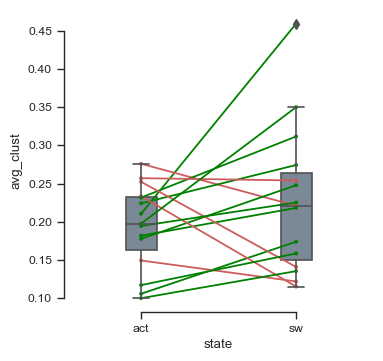

In [58]:
from scipy.stats import wilcoxon
from drn_interactions.stats import mannwhitneyu_plusplus
import pingouin as pg

piv = df_graph.pivot(index="session", columns="state", values="avg_clust")
x = piv.sw
y = piv.act
print(mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=wilcoxon))

pg.plot_paired(df_graph, dv="avg_clust", within="state", subject="session")

n_sw        15.000000
n_act       15.000000
Mean_sw      3.353019
Mean_act     2.688239
Diff        -0.664780
U           29.000000
p            0.083252
dtype: float64


<AxesSubplot:xlabel='state', ylabel='avg_deg'>

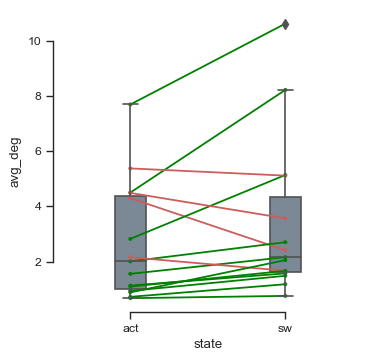

In [60]:
piv = df_graph.pivot(index="session", columns="state", values="avg_deg")
x = piv.sw
y = piv.act
print(mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=wilcoxon))

pg.plot_paired(df_graph, dv="avg_deg", within="state", subject="session")

n_sw          315.000
n_act         315.000
Mean_sw         0.144
Mean_act        0.135
Diff           -0.009
U           11131.000
p               0.000
dtype: float64


<AxesSubplot:xlabel='state', ylabel='degree'>

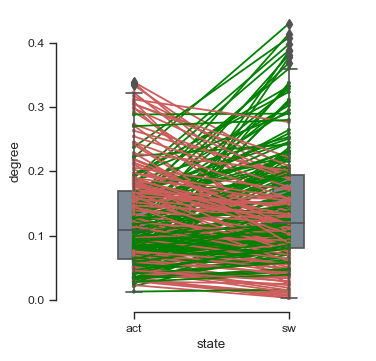

In [73]:
metric = "degree"

piv = (
    df_node
    [["neuron_id", "state", metric]]
    .drop_duplicates()
    .pivot(index="neuron_id", columns="state", values=metric)
)
x = piv.sw
y = piv.act
print(mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=wilcoxon).round(3))

pg.plot_paired(df_node, dv=metric, within="state", subject="neuron_id")

n_sw          315.00
n_act         315.00
Mean_sw         0.20
Mean_act        0.22
Diff            0.02
U           12050.00
p               0.00
dtype: float64


<AxesSubplot:xlabel='state', ylabel='clust'>

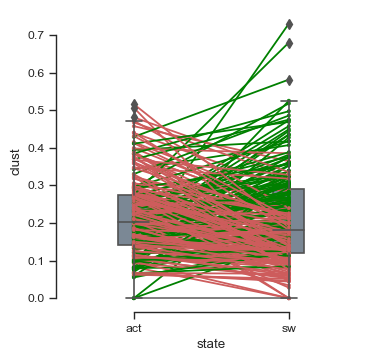

In [75]:
metric = "clust"

piv = (
    df_node
    [["neuron_id", "state", metric]]
    .drop_duplicates()
    .pivot(index="neuron_id", columns="state", values=metric)
)
x = piv.sw
y = piv.act
print(mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=wilcoxon).round(2))

pg.plot_paired(df_node, dv=metric, within="state", subject="neuron_id")